<a id="top"></a>
 <font size="5">BAPC</font>
> 

> * Prepared by Alfredo López
> * alfredo.lopez@scch.at
> 
<hr>
<hr>

# Import

In [1]:
import os
import numpy as np
import pandas as pd
import pitsa_lite as pitsa
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display

# Workflow

- **Inputs**  
    - **Data** A time series from a sinusoidal with a change in amplitud and phase (non-homogeneous driven harmonic oscillator) 
    - **Base model** : robust AR(2) $f_{(\varphi_1, \varphi_2)}(t) = \Phi_1(t, \varphi)y_2 + \Phi_2(t, \varphi)y_1$ depending on a parameter $\theta=(\varphi_1, \varphi_2)$ the auto regressive coefficients
    - **Correction model**: K-Neares-Neighboor (default) or LSTM 
- **BAPC**
- **Explainability**  
    - **Explanation**: vector $\Delta \theta$.
    - **Importance**: vector $I \theta $

# Input

In [2]:
csv_file = '4_sinfcp'

base_model_name = 'RobustAutoRegressiveRegression'
correction_model_name = 'KNN' # fast but less accurate forecast
#correction_model_name = 'LSTM' # slow but more accurate forecast

forecast_lenght = 0 #forecast lenght
correction_window = 80 # correction window size

# Folders

In [3]:
# Please enter the input data folder 
data_folder = '../../../2_data/processed/synthetic'

# Please enter the output figure folder
fig_base = '../../../4_results/figures'

# save the figures ?
save_fig = True

# current convention
notebook_name, _  = os.path.splitext(os.path.basename(globals()['__vsc_ipynb_file__']))
fig_folder = os.path.join(fig_base, notebook_name)

if save_fig and not os.path.exists(fig_folder):
    print('Folder {} was created'.format(fig_folder))
    os.mkdir(fig_folder)

# Data

Figure ../../../4_results/figures\2_4_bapc_sinfcp\4_sinfcp_data.png was saved


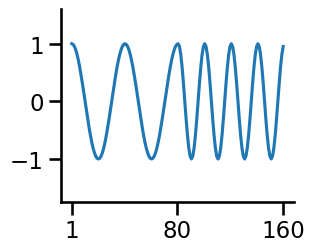

In [4]:
# time series reading
file_name = os.path.join(data_folder, csv_file + '.csv')
df = pd.read_csv(file_name, index_col='t')
df.reset_index(drop=True, inplace=True)

# plot
tast = 80
t = df.index.values
n_train = df.shape[0]

with sns.plotting_context("talk"):
    
    f, ax = plt.subplots(figsize=(3, 2.5))
    ax.plot(df.index, df['y'], color='tab:blue', label=r'$y$')

    xticks = np.array([0, tast-1, n_train-1])
    ax.set_xticks(xticks, labels=xticks+1)
    plt.locator_params(axis='y', nbins=3)
    ylim = (-1.74, 1.6) # this is for the paper only
    ax.set_ylim(ylim)
    sns.despine()

    if save_fig:
        fig_name = os.path.join(fig_folder, '{}_data.png'.format(csv_file))
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
        print('Figure {} was saved'.format(fig_name))

# Base model

In [5]:
if base_model_name == 'RobustAutoRegressiveRegression':
    fit_args = {'robust':tast}
    base_model = pitsa.models.timeseries.RobustAutoRegressive(fit_args=fit_args)
else:
    error_msg = 'Model {} is not instantiated. Use this place to instantiate your new base model'.format(base_model_name)
    raise ValueError(error_msg)

# Correction model

In [6]:
if correction_model_name == 'KNN':
    model = KNeighborsRegressor(n_neighbors=1) #Set n_neighbors=1 for perfect fit
    correction_model = pitsa.models.regression.SKLearnModel(model, name='1NN')
elif correction_model_name == 'LSTM':
    fit_args={'epochs':400, 'verbose':False}
    period = 48
    ar_order = int(period/2)
    SEED = 2022
    correction_model = pitsa.models.timeseries.RNN(model=None, ar_order=ar_order, fit_args=fit_args, name='LSTM')
    correction_model.initialize(lstm_units=16, SEED=SEED)

# BAPC

In [7]:
# intialize
explainer = pitsa.xai.bapc.Explainer(
base_model=base_model, 
correction_model=correction_model
)

# train data
t = df['y'] .index.values
y = df['y'] .values.flatten()

# update
explainer.update(t=t, y=y, correction_window=correction_window, fit_residual=True)

# forecast
if forecast_lenght > 0: 
    explainer.forecast(forecast_lenght=forecast_lenght)

# Explainability

Figure was saved as ../../../4_results/figures\2_4_bapc_sinfcp\4_sinfcp_bapc.png


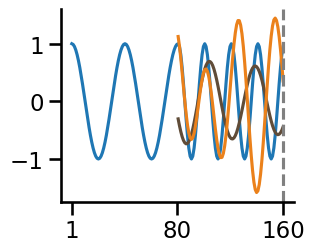

In [8]:
with sns.plotting_context("talk"):

    ax = explainer.plot(figsize=(3, 2.5)) 
    plt.locator_params(axis='x', nbins=3)
    plt.locator_params(axis='y', nbins=3)
    ax.set_xticks(xticks, labels=xticks+1)
    ax.axvline(x=n_train - 1, color='gray', linestyle='--')
    ax.set_ylim(ylim) # this is for the paper only
    sns.despine()

    # save the figure
    if save_fig:
        fig_name = os.path.join(fig_folder, '{}_bapc.png'.format(csv_file))
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
        print('Figure was saved as {}'.format(fig_name))

In [9]:
# integrated gradient at t
t = n_train - 1

explanation, importance = explainer.explain(t=t, hp=True, precision=60)
    
display(100*explanation.round(3))
display(100*importance.round(2))

surrogate_correction = explainer.first_base_model_at_t_test[t] - explainer.second_base_model_at_t_test[t]
assert np.allclose(np.sum(importance.values), surrogate_correction, atol=0.01), 'Sum of the importance ({}) is not equal to the surrogate correction ({})'.format(np.sum(importance.values), surrogate_correction)

Computing IG for AR model with high precision
Precision: 60


,ar.L1,ar.L2
159,-3.1,0.3


,ar.L1,ar.L2
159,46.0,-6.0


In [10]:
def ar_to_sin(phi1, phi2, y1, y2):
    # Formulas in Proposition 2

    beta = -0.5*np.log(-phi2)
    omega = np.arccos(0.5*phi1*np.exp(beta))
    tgphi = (y1*np.exp(-beta)*np.cos(omega) - y2)/(y1*np.exp(-beta)*np.sin(omega))
    alpha = y1*np.sqrt(1 + tgphi**2)
    phi = np.arctan(tgphi)

    return alpha, beta, omega, phi 

params_bf = explainer.first_base_model.params
params_af = explainer.second_base_model.params
ics_bf = explainer.first_base_model.ics
ics_af = explainer.second_base_model.ics

amplitude_bf, decay_bf, frequency_bf, phase_bf = ar_to_sin(phi1=params_bf['ar.L1'], 
                                                phi2=params_bf['ar.L2'], 
                                                y1=ics_bf[0], 
                                                y2=ics_bf[1])

amplitude_af, decay_af, frequency_af, phase_af = ar_to_sin(phi1=params_af['ar.L1'],
                                                phi2=params_af['ar.L2'],
                                                y1=ics_af[0],
                                                y2=ics_af[1])

print('Before: amplitude={:.2f}, decay={:.2f}, frequency={:.2f}, phase={:.2f}'.format(amplitude_bf, decay_bf, frequency_bf, phase_bf))
print('After: amplitude={:.2f}, decay={:.2f}, frequency={:.2f}, phase={:.2f}'.format(amplitude_af, decay_af, frequency_af, phase_af))

theta_bf = {'amplitude': amplitude_bf, 'decay': decay_bf, 'frequency': frequency_bf, 'phase': phase_bf}
theta_af = {'amplitude': amplitude_af, 'decay': decay_af, 'frequency': frequency_af, 'phase': phase_af}


explanation, importance = pitsa.xai.importance.integrated_gradient(t, theta_bf, theta_af, model='KernelBasisFunction')
display(100*explanation.round(3))
display(100*importance.round(3))

surrogate_correction = explainer.first_base_model_at_t_test[t] - explainer.second_base_model_at_t_test[t]
assert np.allclose(np.sum(importance.values), surrogate_correction, atol=0.01), 'Sum of the importance ({}) is not equal to the surrogate correction ({})'.format(np.sum(importance.values), surrogate_correction)


Before: amplitude=1.00, decay=0.01, frequency=0.25, phase=-0.09
After: amplitude=1.00, decay=0.00, frequency=0.18, phase=-0.04


,intercept,slope,quadratic,amplitude,decay,frequency,phase
0,0,0,0,0.4,0.2,6.6,-5.2


,intercept,slope,quadratic,amplitude,decay,frequency,phase
159,0.0,0.0,0.0,0.0,-1.9,41.7,-0.2


# Bottom